<a href="https://www.kaggle.com/code/mikedelong/eda-with-map?scriptVersionId=137049285" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/los-angeles-crime-dataset-2020-present/Crime_Data_from_2020_to_Present.csv', 
                 parse_dates=['Date Rptd', 'DATE OCC']).drop(columns=['DR_NO'])
df.sample(n=7)

,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
676118,2023-06-07,2023-06-07,1740,13,Newton,1351,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),1309 0344 0104 0325,...,IC,Invest Cont,442.0,NaN,NaN,NaN,4000 S MAIN ST,NaN,34.0075,-118.2775
38070,2020-12-13,2020-12-13,2200,6,Hollywood,639,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,0913 1814 0400 0448 0444 0429 2000 1813,...,AO,Adult Other,626.0,NaN,NaN,NaN,1700 N SERRANO AV,NaN,34.1017,-118.3072
750346,2023-01-28,2023-01-26,300,6,Hollywood,649,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,1813 1814 0401 2000 0400 0447,...,AO,Adult Other,626.0,NaN,NaN,NaN,1500 N HOBART BL,NaN,34.0981,-118.3056
171803,2020-07-14,2020-07-14,200,18,Southeast,1802,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0913 0603 0361 0334 0443 0329,...,IC,Invest Cont,740.0,NaN,NaN,NaN,200 W 91ST ST,NaN,33.9537,-118.2757
544984,2022-10-05,2022-10-05,1600,6,Hollywood,645,1,440,THEFT PLAIN - PETTY ($950 & UNDER),0400 0913 0344 0503 0522 0448,...,IC,Invest Cont,440.0,860.0,NaN,NaN,6800 FRANKLIN AV,NaN,34.1042,-118.3383
559948,2022-07-17,2022-07-15,600,8,West LA,859,1,510,VEHICLE - STOLEN,NaN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,8500 W PICO BL,NaN,34.0533,-118.3762
512056,2022-02-16,2022-02-15,1325,11,Northeast,1107,2,662,"BUNCO, GRAND THEFT",0701,...,IC,Invest Cont,662.0,NaN,NaN,NaN,1800 UPPERTON AV,NaN,34.1278,-118.1953


In [2]:
df.columns

Index(['Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No',
       'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex',
       'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd',
       'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2',
       'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: xlabel='Vict Age', ylabel='Density'>

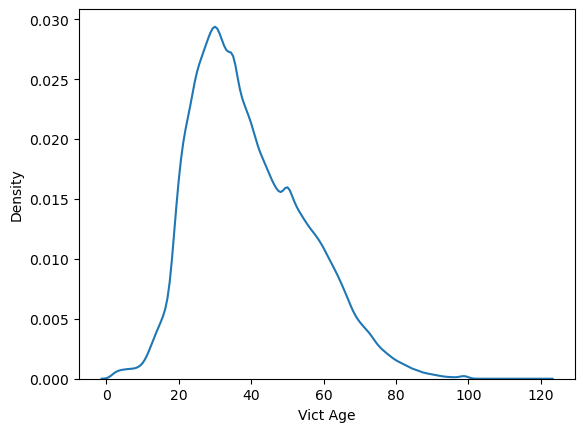

In [3]:
# let's look at some distributions
%matplotlib inline
from seaborn import kdeplot
# we need to drop ages = 0 to filter out unknowns
kdeplot(data=df[df['Vict Age'] > 0], x='Vict Age')

In [4]:
from folium import Map
from folium import Marker

sample_size = 1000
sample_df = df.sample(sample_size)

# for some reason we have to fudge the center a little
lon_fudge = -0.5
location_map = Map(location=[sample_df['LAT'].mean(), sample_df['LON'].mean() + lon_fudge], zoom_start=10)
for index, row in sample_df.iterrows():
    popup = '{}/{}/{}:{}'.format(row['LOCATION'], row['AREA NAME'], row['Crm Cd Desc'], row['Status'])
    Marker([row['LAT'], row['LON']], popup=popup).add_to(parent=location_map)

location_map

In [5]:
df.shape

(752911, 27)

In [6]:
df['Crm Cd'].nunique()

138

We have 138 codes; clearly we can't make sense of a pie with that many slices, so let's look at the top ten or so

In [7]:
crime_code_value_counts = df['Crm Cd Desc'].value_counts()
code_df = pd.DataFrame(data={'Code': crime_code_value_counts.index, 'Count': crime_code_value_counts.values}).reset_index(drop=True)
code_df.head(10)

,Code,Count
0,VEHICLE - STOLEN,80439
1,BATTERY - SIMPLE ASSAULT,59630
2,THEFT OF IDENTITY,48645
3,BURGLARY FROM VEHICLE,46526
4,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",46157
5,BURGLARY,45717
6,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",43149
7,THEFT PLAIN - PETTY ($950 & UNDER),38510
8,INTIMATE PARTNER - SIMPLE ASSAULT,37947
9,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),29310


In [8]:
import plotly.express as px
code_df.loc[code_df['Count'] < 15000, 'Code'] = 'Other' # we have too many codes so let's apply a threshold
px.pie(code_df, names='Code', values='Count').show()

In [9]:
# Surely the areas are shaped so the crime is roughly the same in each one; right?
area_value_counts = df['AREA NAME'].value_counts()
area_df = pd.DataFrame(data={'Area': area_value_counts.index, 'Count': area_value_counts.values}).reset_index(drop=True)
px.pie(area_df, names='Area', values='Count').show()

In [10]:
victim_descent = df['Vict Descent'].replace(to_replace={'B': 'Black', 'H': 'Hispanic', 'W': 'White',}).value_counts()
descent_df = pd.DataFrame(data={'Descent': victim_descent.index, 'Count': victim_descent.values}).reset_index(drop=True)
descent_df.loc[descent_df['Count'] < 80000, 'Descent'] = 'Other' # threshold
px.pie(descent_df, names='Descent', values='Count').show()

<Axes: xlabel='DATE OCC'>

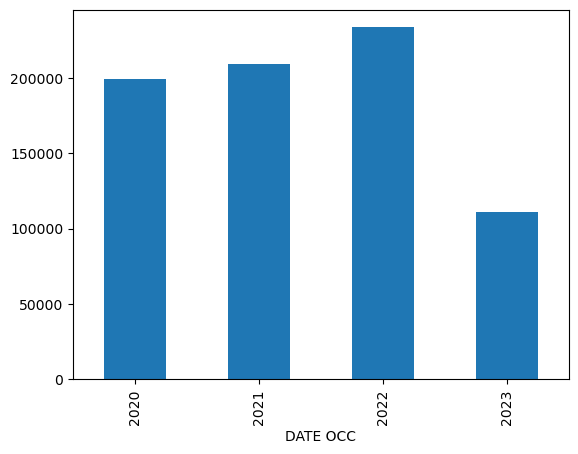

In [11]:
# not surprisingly we have an incomplete current year
df['DATE OCC'].groupby(df['DATE OCC'].dt.year).count().plot(kind='bar')

<Axes: xlabel='DATE OCC'>

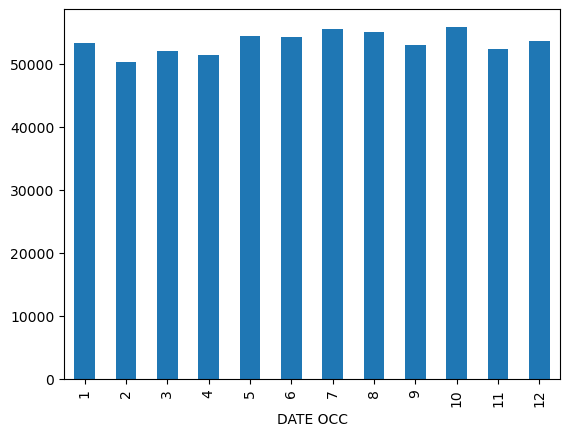

In [12]:
# where we have complete years we do not have obvious seasonality
df[df['DATE OCC'].dt.year < 2023]['DATE OCC'].groupby(df['DATE OCC'].dt.month).count().plot(kind='bar')

<Axes: xlabel='DATE OCC'>

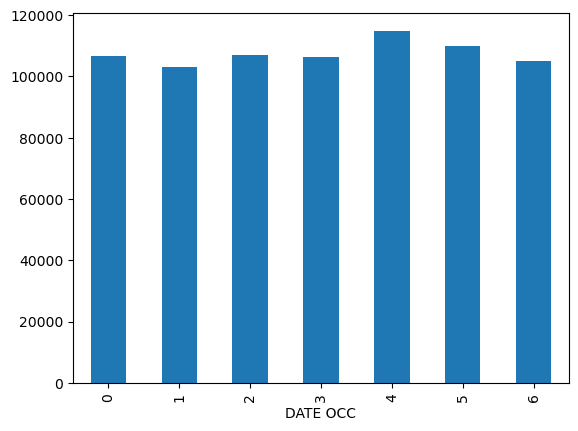

In [13]:
# nor do weekends seem to matter much
df['DATE OCC'].groupby(df['DATE OCC'].dt.dayofweek).count().plot(kind='bar')

<Axes: xlabel='DATE OCC', ylabel='Density'>

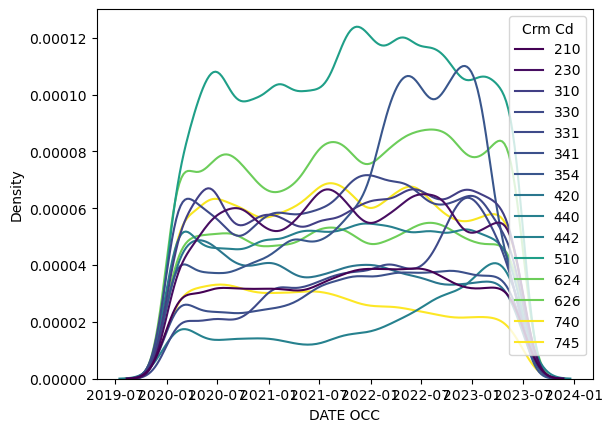

In [14]:
# if we segment by crime code do we see anything interesting?
kdeplot(data=df[df['Crm Cd'].isin(df['Crm Cd'].value_counts()[:15].index.tolist())], x='DATE OCC', hue='Crm Cd', palette='viridis')

<Axes: xlabel='DATE OCC', ylabel='Density'>

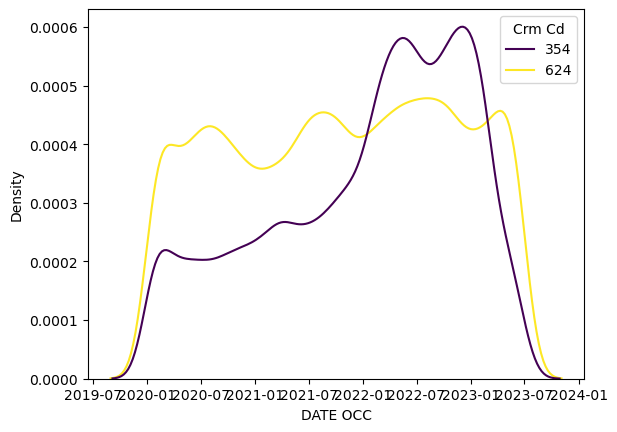

In [15]:
# we see a persistent surge in one code; which one is it?
kdeplot(data=df[df['Crm Cd'].isin(df['Crm Cd'].value_counts()[1:3].index.tolist())], x='DATE OCC', hue='Crm Cd', palette='viridis')

In [16]:
df[df['Crm Cd'].isin(df['Crm Cd'].value_counts()[:10].index.tolist())][['Crm Cd', 'Crm Cd Desc']].drop_duplicates()

,Crm Cd,Crm Cd Desc
0,624,BATTERY - SIMPLE ASSAULT
4,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA..."
10,330,BURGLARY FROM VEHICLE
15,626,INTIMATE PARTNER - SIMPLE ASSAULT
17,440,THEFT PLAIN - PETTY ($950 & UNDER)
18,354,THEFT OF IDENTITY
24,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT"
30,310,BURGLARY
33,510,VEHICLE - STOLEN
45,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)


Identity theft seems like kind of a surprise, doesn't it?